### FT Transformer

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
import matplotlib.pyplot as plt
import time

# Load dataset
from ucimlrepo import fetch_ucirepo
online_original = fetch_ucirepo(id=468)
online_shoppers = online_original.data.original

# Encode target
df = online_shoppers.copy()
df['Revenue'] = df['Revenue'].astype(int)
y = df['Revenue']

# Split categorical and numerical features
categorical_cols = ['Month', 'VisitorType', 'Weekend']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['Revenue']]

# Encode categorical features
encoder = OrdinalEncoder()
X_cat = encoder.fit_transform(df[categorical_cols]).astype(int)

# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_cols])

# Get category sizes
category_sizes = [int(X_cat[:, i].max() + 1) for i in range(X_cat.shape[1])]

# Split into train, val, test
X_cat_temp, X_cat_test, X_num_temp, X_num_test, y_temp, y_test = train_test_split(
    X_cat, X_num, y, test_size=0.2, random_state=42, stratify=y
)
X_cat_train, X_cat_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_cat_temp, X_num_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# Convert to PyTorch tensors
X_cat_train_tensor = torch.tensor(X_cat_train, dtype=torch.long)
X_cat_val_tensor = torch.tensor(X_cat_val, dtype=torch.long)
X_cat_test_tensor = torch.tensor(X_cat_test, dtype=torch.long)
X_num_train_tensor = torch.tensor(X_num_train, dtype=torch.float32)
X_num_val_tensor = torch.tensor(X_num_val, dtype=torch.float32)
X_num_test_tensor = torch.tensor(X_num_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_num_train_tensor, X_cat_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(X_num_val_tensor, X_cat_val_tensor, y_val_tensor), batch_size=256)
test_loader = DataLoader(TensorDataset(X_num_test_tensor, X_cat_test_tensor, y_test_tensor), batch_size=256)

# Define FTTransformer model
model = FTTransformer.make_default(
    n_num_features=X_num_train.shape[1],
    cat_cardinalities=category_sizes,
    d_out=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()



Epoch 1 | Train Loss: 11.3848 | Val Loss: 2.0106
Epoch 2 | Train Loss: 8.1355 | Val Loss: 1.9096
Epoch 3 | Train Loss: 7.6510 | Val Loss: 1.8467
Epoch 4 | Train Loss: 7.3907 | Val Loss: 1.8149
Epoch 5 | Train Loss: 7.3284 | Val Loss: 1.8180
Epoch 6 | Train Loss: 7.3572 | Val Loss: 1.8439
Epoch 7 | Train Loss: 7.1750 | Val Loss: 1.8650
Early stopping triggered.


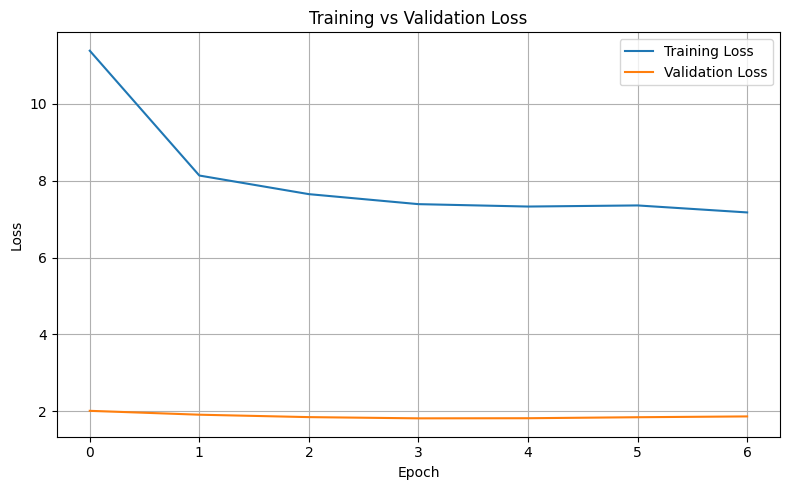

In [4]:
# Training with early stopping and loss tracking
best_val_loss = float('inf')
patience = 3
patience_counter = 0
num_epochs = 100
train_losses = []
val_losses = []

start_time = time.time()



for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_num_batch, x_cat_batch, y_batch in train_loader:
        x_num_batch, x_cat_batch, y_batch = x_num_batch.to(device), x_cat_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_num_batch, x_cat_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_num_batch, x_cat_batch, y_batch in val_loader:
            x_num_batch, x_cat_batch, y_batch = x_num_batch.to(device), x_cat_batch.to(device), y_batch.to(device)
            logits = model(x_num_batch, x_cat_batch)
            loss = loss_fn(logits, y_batch)
            val_loss += loss.item()

    train_losses.append(total_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_ft_transformer.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

ftt_train_time = time.time() - start_time

# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Epoch 12 | Train Loss: 6.9177 | Val Loss: 1.7769
# Early stopping triggered.

In [5]:

# Load best model
model.load_state_dict(torch.load("best_ft_transformer.pt"))
model.eval()


# Evaluate on test set
start_time = time.time()
all_preds, all_probs, all_targets = [], [], []
with torch.no_grad():
    for x_num_batch, x_cat_batch, y_batch in test_loader:
        x_num_batch, x_cat_batch = x_num_batch.to(device), x_cat_batch.to(device)
        logits = model(x_num_batch, x_cat_batch)
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_targets.extend(y_batch.numpy())

ftt_test_time = time.time() - start_time

acc = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
prec = precision_score(all_targets, all_preds)
rec = recall_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)

print("\nFinal Evaluation on Test Set")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")


# Result
#Final Evaluation on Test Set
#Accuracy: 0.8970 | F1: 0.6718 | Precision: 0.6633 | Recall: 0.6806 | AUC: 0.9220


# Final Evaluation on Test Set
# Accuracy: 0.8974 | F1: 0.6381 | Precision: 0.7035 | Recall: 0.5838 | AUC: 0.9230


Final Evaluation on Test Set
Accuracy: 0.8933 | F1: 0.5884 | Precision: 0.7315 | Recall: 0.4921 | AUC: 0.9256
